# This is the pytorch implementation of "Textural weighted fusion"

In [ ]:
#Import packages
import time
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import numpy as np
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.models.vgg import vgg19
import torch.nn as nn
import torch.nn.functional as F
import torch
from skimage import img_as_ubyte
import torch.nn as nn
import torch.utils.data as Data
import torchvision      # dataset
import matplotlib.pyplot as plt
import scipy
import numpy as np
import argparse
import glob
import imageio
from skimage import color
import numpy
import natsort
import scipy
import pprint
from scipy.ndimage import correlate
from scipy.ndimage.filters import gaussian_gradient_magnitude
import torchvision.datasets as dset
import torch.utils.data as data
import os
import os.path
from tkinter import *
import tkinter as tk
import tkinter.font as tkFont
from PIL import ImageTk, Image
import pylab
import cv2
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.font_manager import FontProperties
import torch
import torch.nn.functional as F
import numpy as np
import math
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import matplotlib
import matplotlib.pyplot as plt

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Dataset-new

/content/drive/.shortcut-targets-by-id/1uVtwMbKudULDh5ogssCQcQS30RUY-8oK/Dataset-new


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_properties(0).total_memory)

15843721216


In [ ]:
import multiprocessing
import fast_glcm
multiprocessing.cpu_count()

2

In [ ]:
#define the hyperparameters
image_length = 256
image_width  = 256
mr_channels  = 1
gray_channels = 1
ct_channels = 4
rgb_channels = 3
batch_size   = 1
EPOCH = 10
learning_rate = 0.002
import torch.nn.functional as F
import sys
np.set_printoptions(threshold=sys.maxsize)


In [ ]:
#load the train mri data

filenames = os.listdir('MRIGIF')
dataset = os.path.join(os.getcwd(), 'MRIGIF')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
train_mri = np.zeros((len(data),image_width,image_length))
for i in range(len(data)):
      train_mri[i] =(imageio.imread(data[i]))




In [ ]:
#expand dimension to add the channel
train_mri = np.expand_dims(train_mri,axis=1)
#expand dimension to add the channel
train_mri = np.expand_dims(train_mri,axis=1)

In [ ]:
#verify the shape matches the pytorch standard
train_mri.shape

(204, 1, 1, 256, 256)

In [ ]:
#convert the MRI training data to pytorch tensor
train_mri_tensor = torch.from_numpy(train_mri).float()
train_mri_tensor.shape

torch.Size([204, 1, 1, 256, 256])

In [ ]:
#load the train ct data
filenames = os.listdir('CTGIF')
dataset = os.path.join(os.getcwd(), 'CTGIF')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
train_ct = np.zeros((len(data),image_width,image_length),dtype=float)
for i in range(len(data)):
      train_ct[i,:,:] =(imageio.imread(data[i]))

In [ ]:
#expand the dimension to add the channel
train_ct = np.expand_dims(train_ct,axis=1)#expand the dimension to add the channel
train_ct = np.expand_dims(train_ct,axis=1)

In [ ]:
#verify the shape matches the pytorch standard
train_ct.shape

(204, 1, 1, 256, 256)

In [ ]:
#convert the ct training data to pytorch tensor
train_ct_tensor = torch.from_numpy(train_ct).float()
train_ct_tensor.shape

torch.Size([204, 1, 1, 256, 256])

In [ ]:
#load the train ct data
filenames = os.listdir('Alloutputs')
dataset = os.path.join(os.getcwd(), 'Alloutputs')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
train_other = np.zeros((len(data),image_width,image_length,ct_channels),dtype=float)
train_gt = np.zeros((len(data),image_width,image_length),dtype=float)
for i in range(len(data)):
    train_gt[i]=(imageio.imread(data[i]))


In [ ]:
#expand the dimension to add the channel
train_gt = np.expand_dims(train_gt,axis=1)
train_gt = np.expand_dims(train_gt,axis=1)

In [ ]:
#verify the shape matches the pytorch standard
train_gt.shape

(204, 256, 256)

In [ ]:
#convert the ct training data to pytorch tensor
train_gt_tensor = torch.from_numpy(train_gt).float()
train_gt_tensor.shape

torch.Size([204, 1, 1, 256, 256])

In [ ]:
#
'''---------------------------------------------------------------------------
# Proposed image fusion framework
# ----------------------------------------------------------------------------'''
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import skimage.feature as ski
import numpy as np


plt.rcParams['image.cmap'] = 'gray'
# # My Convolution Block
class ConvBlock(nn.Module):
    def __init__(self, inplane, outplane):
        super(ConvBlock, self).__init__()
        self.padding = (1, 1, 1, 1)
        self.conv = nn.Conv2d(inplane, outplane, kernel_size=3, padding=0, stride=1, bias=False)
        self.bn = nn.BatchNorm2d(outplane)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = F.pad(x, self.padding, 'replicate')
        out = self.conv(out)
        out = self.bn(out)
        out = self.relu(out)
        return out


class Proposed(nn.Module):
    def __init__(self, resnet, fuse_scheme=0):
        super(Proposed, self).__init__()
        self.fuse_scheme = fuse_scheme # MAX, MEAN, SUM
        self.conv1 = ConvBlock(1,64)
        self.conv2 = ConvBlock(64, 64)
        self.conv3 = ConvBlock(64, 64)
        self.conv4 = nn.Conv2d(64, 1, kernel_size=1, padding=0, stride=1, bias=True)

        # Initialize parameters for other parameters
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))

    def operate(self, operator, tensors):
        out_tensors = []
        for tensor in tensors:
            out_tensor = operator(tensor)
            out_tensors.append(out_tensor)
        return out_tensors

    def tensor_padding(self, tensors, padding=(1, 1, 1, 1), mode='constant', value=0):
        out_tensors = []
        for tensor in tensors:
            out_tensor = F.pad(tensor, padding, mode=mode, value=value)
            out_tensors.append(out_tensor)
        return out_tensors

    def forward(self, *tensors):
        # Feature extraction
        outs = self.operate(self.conv1, tensors)
        outs = self.operate(self.conv2, outs)
        imgs_sum_maps = [-1 for tensor_img in tensors]
        for idx,feature_map in enumerate(outs):
              imgs_sum_maps[idx]=[]
              sum_map1 = torch.sum(feature_map, dim=1, keepdim=True)
              imgs_sum_maps[idx].append(sum_map1)
        for sum_maps in zip(*imgs_sum_maps):
                features = torch.cat(sum_maps, dim=0)
                weights = self._generator(features)
                current_fusion = torch.zeros(tensors[0].shape).to(device)
                for idx, tensor_img in enumerate(tensors):
                    current_fusion += (tensor_img) * weights[idx,0]
        return current_fusion
    def _generator(self, tensor1):
            """
            A private method which compute generator ouput of a given tensor
            """
            arr1=(tensor1[0][0]).cpu().detach().numpy()
            arr2=(tensor1[1][0]).cpu().detach().numpy()
            WA=fast_glcm.fast_glcm_mean(arr1)
            WB=fast_glcm.fast_glcm_mean(arr2)
            for i in range(256):
              for j in range(256):
                if(WA[i][j]>WB[i][j]):
                      tensor1[0][0][i][j]=1
                      tensor1[1][0][i][j]=0
                elif(WA[i][j]<WB[i][j]):
                      tensor1[0][0][i][j]=0
                      tensor1[1][0][i][j]=1
                elif(WA[i][j]==WB[i][j]):
                    tensor1[0][0][i][j]=0.5
                    tensor1[1][0][i][j]=0.5
            return(tensor1)
    def fast_glcm_mean(self, img, vmin=0, vmax=255, nbit=8, ks=5):

        h,w = img.size()
        glcm = self.fast_glcm(img, vmin, vmax, nbit, ks)
        mean = torch.zeros((h,w), dtype=torch.float32)
        for i in range(nbit):
            for j in range(nbit):
                mean += glcm[i,j] * i / (nbit)**2

        return mean
    def fast_glcm(self,img, vmin=0, vmax=255, nbit=8, kernel_size=5):
        mi, ma = vmin, vmax
        ks = kernel_size
        h,w = img.size()
        bins = (torch.linspace(mi, ma+1, nbit+1)).to(device)
        gl1 = torch.bucketize(img, bins)-1
        gl2 = torch.cat((gl1[:,1:], gl1[:,-1:]), axis=1)

        # make glcm
        glcm = torch.zeros((nbit, nbit, h, w), dtype=torch.uint8)
        for i in range(nbit):
            for j in range(nbit):
                mask = ((gl1==i) & (gl2==j))
                glcm[i,j, mask] = 1
        glcm = glcm.type(torch.float32)
        return glcm





def myProposed(fuse_scheme=0):
    # pretrained resnet101
    resnet = models.resnet101(pretrained=True)
    # our model
    model = Proposed(resnet, fuse_scheme=fuse_scheme)
    return model
cnn = myProposed().to(device)
cnn = cnn.float()
print(cnn)

Proposed(
  (conv1): ConvBlock(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv2): ConvBlock(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv3): ConvBlock(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv4): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)


In [ ]:
def gaussian(window_size, sigma):
    """
    Generates a list of Tensor values drawn from a gaussian distribution with standard
    diviation = sigma and sum of all elements = 1.

    Length of list = window_size
    """
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()
def create_window(window_size, channel=1):

    # Generate an 1D tensor containing values sampled from a gaussian distribution
    _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)

    # Converting to 2D
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)

    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())

    return window

def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):

    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),

    pad = window_size // 2

    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()

    # if window is not provided, init one
    if window is None:
        real_size = min(window_size, height, width) # window should be atleast 11x11
        window = create_window(real_size, channel=channels).to(img1.device)

    # calculating the mu parameter (locally) for both images using a gaussian filter
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean()
    else:
        ret = ssim_score.mean(1).mean(1).mean(1)

    if full:
        return ret, contrast_metric

    return ret


In [ ]:
import torch.nn as nn
torch.set_printoptions(profile="full")
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)   # optimize all cnn parameters
l2_loss   = torch.nn.MSELoss()#MSEloss

Epoch: [ 0],step: [100], mri_ssim_loss: [0.30738115], ct_ssim_loss: [0.33473599],  total_ssim_loss: [0.32105857], total_l2_loss: [3535.54052734], total_loss: [1767.93078613]
Epoch: [ 0],step: [200], mri_ssim_loss: [0.29050833], ct_ssim_loss: [0.35055429],  total_ssim_loss: [0.32053131], total_l2_loss: [3688.38574219], total_loss: [1844.35314941]
Epoch: [ 1],step: [300], mri_ssim_loss: [0.38097668], ct_ssim_loss: [0.33901888],  total_ssim_loss: [0.35999778], total_l2_loss: [5186.67578125], total_loss: [2593.51782227]
Epoch: [ 1],step: [400], mri_ssim_loss: [0.26109701], ct_ssim_loss: [0.28459066],  total_ssim_loss: [0.27284384], total_l2_loss: [3270.76245117], total_loss: [1635.51770020]
Epoch: [ 2],step: [500], mri_ssim_loss: [0.44654393], ct_ssim_loss: [0.47040439],  total_ssim_loss: [0.45847416], total_l2_loss: [5238.34326172], total_loss: [2619.40087891]
Epoch: [ 2],step: [600], mri_ssim_loss: [0.26314235], ct_ssim_loss: [0.20840192],  total_ssim_loss: [0.23577213], total_l2_loss: [

KeyboardInterrupt: ignored

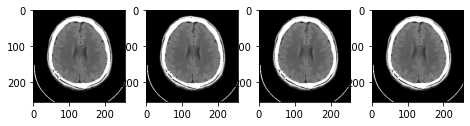

In [ ]:
# perform the training
BS=2
counter = 0
start_time = time.time()
lamda = 0.5
gamma_ssim = 0.5
gamma_l2 = 0.5
ep_ssim_mri_loss = []
ep_ssim_ct_loss = []
ep_l2_mri_loss = []
ep_l2_ct_loss = []
ep_total_loss=[]
fig=plt.figure(figsize=(30,30))
for epoch in range(EPOCH):
    ssim_mri_Loss = []
    ssim_ct_Loss = []
    l2_mri_Loss = []
    l2_ct_Loss = []
    total_loss=[]
    #run batch images
    batch_idxs = 204 // batch_size
    cnn.train(True)
    for idx in range(batch_idxs):
        b_x = train_mri_tensor[idx].type(torch.float32).to(device)
        b_y = train_ct_tensor[idx].type(torch.float32).to(device)

        counter += 1
        output = cnn(b_x,b_y)
        if(idx==18):
          fig.add_subplot(15,15,epoch+1)
          plt.imshow(np.squeeze(output.cpu().detach().numpy()))

              # cnn output
        ssim_loss_mri = 1 - ssim(output,b_x,val_range=1)
        ssim_loss_ct = 1 - ssim(output, b_y,val_range=1)
        l2_loss_mri   = l2_loss(output,b_x)
        l2_loss_ct   = l2_loss(output,b_y)
        ssim_total = gamma_ssim*ssim_loss_mri + (1-gamma_ssim)*ssim_loss_ct
        l2_total = gamma_l2*l2_loss_mri + (1-gamma_l2)*l2_loss_ct
        loss_total = lamda*ssim_total + (1-lamda)*l2_total
        optimizer.zero_grad()           # clear gradients for this training step
        loss_total.backward()          # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        #store all the loss values at each epoch
        ssim_mri_Loss.append(ssim_loss_mri.item())
        ssim_ct_Loss.append(ssim_loss_ct.item())
        l2_mri_Loss.append(l2_loss_mri.item())
        l2_ct_Loss.append(l2_loss_ct.item())
        total_loss.append(loss_total.item())

        if counter % 100 == 0:
            print("Epoch: [%2d],step: [%2d], mri_ssim_loss: [%.8f], ct_ssim_loss: [%.8f],  total_ssim_loss: [%.8f], total_l2_loss: [%.8f], total_loss: [%.8f]"
            %(epoch, counter, ssim_loss_mri, ssim_loss_ct, ssim_total, l2_total, loss_total))
    cnn.train(False)
    av_ssim_mri_loss = np.average(ssim_mri_Loss)
    ep_ssim_mri_loss.append(av_ssim_mri_loss)

    av_ssim_ct_loss = np.average(ssim_ct_Loss)
    ep_ssim_ct_loss.append(av_ssim_ct_loss)

    av_l2_mri_loss = np.average(l2_mri_Loss)
    ep_l2_mri_loss.append(av_l2_mri_loss)

    av_l2_ct_loss = np.average(l2_ct_Loss)
    ep_l2_ct_loss.append(av_l2_ct_loss)
    av=np.average(total_loss)
    ep_total_loss.append(av)


    if(epoch==EPOCH-1):
      #Save a checkpoint
      torch.save(cnn.state_dict(), 'GLCM1.pth')
for p in cnn.state_dict():
  print(p, "\t", cnn.state_dict()[p].size())

In [ ]:
torch.save(cnn.state_dict(), 'GLCM1.pth')


In [ ]:
l1 = np.asarray(ep_ssim_mri_loss)
l2 = np.asarray(ep_ssim_ct_loss)
l3 = np.asarray(ep_l2_mri_loss)
l4 = np.asarray(ep_l2_ct_loss)
l5 = np.asarray(ep_total_loss)

In [ ]:
h5f = h5py.File('gamma_0.5_0.5_ssim_mri.h5', 'w')
h5f.create_dataset('data', data=l1)
h5f.close()

h5f = h5py.File('gamma_0.5_0.5_ssim_ct.h5', 'w')
h5f.create_dataset('data', data=l2)
h5f.close()

h5f = h5py.File('gamma_0.5_0.5_l2_mri.h5', 'w')
h5f.create_dataset('data', data=l3)
h5f.close()

h5f = h5py.File('gamma_0.5_0.5_l2_ct.h5', 'w')
h5f.create_dataset('data', data=l4)
h5f.close()

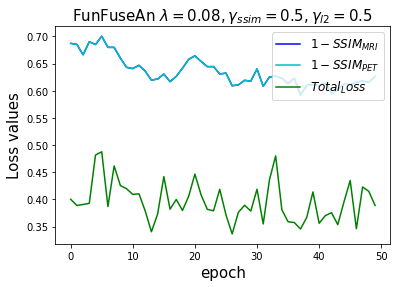

In [ ]:
#FunFuseAn SSIM gamma_ssim = 0.1 gamma_l2 = 0.1
fontP = FontProperties()
fontP.set_size('large')
plt.plot(l1,'b',label='$1-SSIM_{MRI}$')
plt.plot(l2,'c',label='$1-SSIM_{ct}$')
plt.plot(l5,'g',label='$Total_Loss$')
plt.xlabel('epoch',fontsize= 15)
plt.ylabel('Loss values',fontsize= 15)
plt.legend(loc=1, prop=fontP)
plt.title('FunFuseAn $\lambda = 0.08, \gamma_{ssim} = 0.5, \gamma_{l2} = 0.5$',fontsize='15')
plt.savefig('gamma_0.5_0.5_ssim.eps', format='eps', dpi=100)

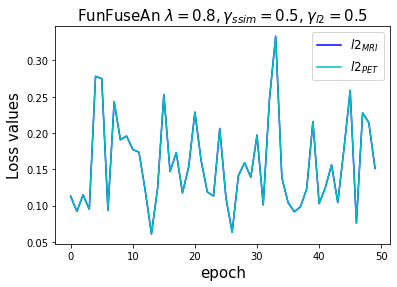

In [ ]:
#FunFuseAn L2 gamma_ssim = 0.1 gamma_l2 = 0.1
fontP = FontProperties()
fontP.set_size('large')
plt.plot(l3,'b',label='$l2_{MRI}$')
plt.plot(l4,'c',label='$l2_{ct}$')
plt.xlabel('epoch',fontsize= 15)
plt.ylabel('Loss values',fontsize= 15)
plt.legend(loc=1, prop=fontP)
plt.title('FunFuseAn $\lambda = 0.8, \gamma_{ssim} = 0.5, \gamma_{l2} = 0.5$',fontsize='15')
plt.savefig('gamma_0.5_0.5_l2.eps', format='eps', dpi=100)

In [ ]:
from PIL import Image

In [ ]:
model = myProposed()
model.load_state_dict(torch.load('GLCMlogic2.pth'))
model.eval()
model = model.cuda()

In [ ]:
from imageio.core.functions import imread
import numpy as np
img1=imread("c07_1.gif")
img2=imread("c07_2.gif")
img1=np.expand_dims(img1,axis=0)
img1=np.expand_dims(img1,axis=0)
img2=np.expand_dims(img2,axis=0)
img2=np.expand_dims(img2,axis=0)

In [ ]:
tensorimg1=torch.from_numpy(img1).float().to(device)
tensorimg2=torch.from_numpy(img2).float().to(device)



In [ ]:
fused=model(tensorimg1,tensorimg2)


AttributeError: ignored

In [ ]:
nufu=fused.cpu().detach().numpy()

In [ ]:
ffused=np.squeeze(nufu)

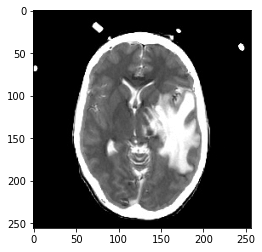

In [ ]:
plt.imshow(ffused)
#matplotlib.image.imsave('Resultsfinal/P07.gif', ffused)

In [ ]:
from matplotlib.transforms import offset_copy
from matplotlib.offsetbox import OffsetImage
from imageio.core.functions import imread
DCS_arr=[]
for i in range(204):
  A=np.squeeze(train_mri[i])
  B=np.squeeze(train_ct[i])
  F=train_gt[i]
  def DCS(A,B):
    num=0
    dem=0
    for i in range(256):
      for j in range(256):
        if(A[i][j]==B[i][j]):
          num=num+1
        else:
          dem=dem+1
    return(num/dem)
  h=np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
  v=np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
  Ah=cv2.filter2D(A,-1,h)
  Av=cv2.filter2D(A,-1,v)
  SA=(Ah*2+Av*2)*0.5
  Bh=cv2.filter2D(B,-1,h)
  Bv=cv2.filter2D(B,-1,v)
  SB=(Bh*2+Bv*2)*0.5
  Fh=cv2.filter2D(F,-1,h)
  Fv=cv2.filter2D(F,-1,v)
  SF=(Fh*2+Fv*Fv)*0.5

  for i in range(256):
    for j in range(256):
      SA[i][j]=np.sqrt(Ah[i][j]*2+Av[i][j]*2)
      SB[i][j]=np.sqrt(Bh[i][j]*2+Bv[i][j]*2)
      SF[i][j]=np.sqrt(Fh[i][j]*2+Fv[i][j]*2)
  DCS_arr.append(DCS(SA,SF)+DCS(SB,SF))
print(sum(DCS_arr)/204)





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


3.282892718147154


In [ ]:
from matplotlib.transforms import offset_copy
from matplotlib.offsetbox import OffsetImage
from imageio.core.functions import imread
np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['image.cmap'] = 'gray'
def DCS(A,B):
  num=0
  dem=0
  for i in range(256):
    for j in range(256):
      if(A[i][j]==B[i][j]):
        num=num+1
      else:
        dem=dem+1
  return(num/dem)
import math
def arctan(RF):
  an=15*RF-0.5
  return(0.5*(np.tanh(an)+0.5))
A=imread("c07_1.gif")
A=np.array(A)
B=imread("c07_2.gif")
B=np.array(B)
F=np.array(imread("Results2/P07.gif"))
#F=cv2.cvtColor(F, cv2.COLOR_RGB2GRAY)
h=np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
v=np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
Ah=cv2.filter2D(A,-1,h)
Av=cv2.filter2D(A,-1,v)
SA=(Ah*2+Av*2)*0.5
Bh=cv2.filter2D(B,-1,h)
Bv=cv2.filter2D(B,-1,v)
SB=(Bh*2+Bv*2)*0.5
Fh=cv2.filter2D(F,-1,h)
Fv=cv2.filter2D(F,-1,v)
SF=(Fh*2+Fv*Fv)*0.5

for i in range(256):
  for j in range(256):
    SA[i][j]=np.sqrt(Ah[i][j]*2+Av[i][j]*2)
    SB[i][j]=np.sqrt(Bh[i][j]*2+Bv[i][j]*2)
    SF[i][j]=np.sqrt(Fh[i][j]*2+Fv[i][j]*2)
print(DCS(SA,SF)+DCS(SB,SF))